### Use log transform

### Test on 2017

In [5]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.models import RandomForestModel
from darts.metrics import mape, mae, rmse
from darts.utils.missing_values import fill_missing_values
from darts.dataprocessing.transformers import BoxCox

sp500 = yf.Ticker("^GSPC")
df = sp500.history(start="2010-01-01", end="2017-12-31")[["Close"]].dropna()
df.index = pd.to_datetime(df.index).tz_localize(None)

# business-day index + ffill
all_bd = pd.date_range(df.index.min(), df.index.max(), freq="B")
df = df.reindex(all_bd)
df["Close"].ffill(inplace=True)

weekly = df["Close"].resample("W-FRI").last().to_frame()

series = TimeSeries.from_series(
    weekly["Close"],
    fill_missing_dates=True,
    freq="W"
)
series = fill_missing_values(series)

C:\Users\USER\AppData\Local\Temp\ipykernel_29712\726494729.py:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Close"].ffill(inplace=True)


In [ ]:
log_tf = BoxCox(lmbda=0) # lambda=0 means log transformation
series_log = log_tf.fit_transform(series)

train_log, test_log = series_log.split_before(pd.Timestamp("2017-01-01"))
h = len(test_log)

In [7]:
rf = RandomForestModel(
    lags=52,                 # use past year of lags
    output_chunk_length=h,   # direct multi-step forecast
    n_estimators=300,
    random_state=42,
    n_jobs=-1
)

rf.fit(train_log)

RandomForestModel(lags=52, lags_past_covariates=None, lags_future_covariates=None, output_chunk_length=52, output_chunk_shift=0, add_encoders=None, n_estimators=300, max_depth=None, multi_models=True, use_static_covariates=True, random_state=42, n_jobs=-1)

In [ ]:
pred_log = rf.predict(n=h, series=train_log)

rf_forecast = log_tf.inverse_transform(pred_log)

test = log_tf.inverse_transform(test_log)

In [18]:
# Shifting upwards
# extract the last training value and the first forecast value
last_train_value = log_tf.inverse_transform(train_log).values()[-1, 0]
first_forecast_value = rf_forecast.values()[0, 0]

# compute the additive offset
offset = last_train_value - first_forecast_value

# shift the entire forecast up (or down) by that offset
rf_forecast_shifted = rf_forecast + offset

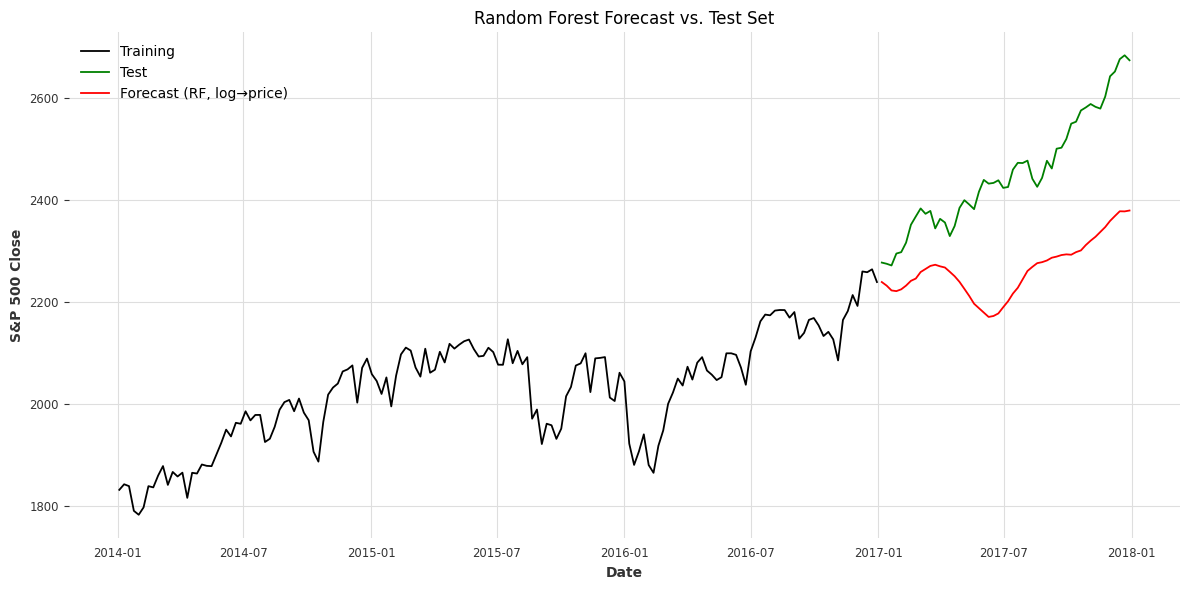

Random Forest (log transformed target)
MAPE: 7.53%
MAE:  187.47
RMSE: 203.28


In [19]:
train_slice = series.slice(pd.Timestamp("2014-01-01"), pd.Timestamp("2016-12-31"))

plt.figure(figsize=(12, 6))
plt.plot(train_slice.time_index, train_slice.values(), label="Training")
plt.plot(series.slice(pd.Timestamp("2017-01-01"), series.end_time()).time_index,
         series.slice(pd.Timestamp("2017-01-01"), series.end_time()).values(),
         label="Test", color="green")
plt.plot(rf_forecast_shifted.time_index, rf_forecast_shifted.values(), label="Forecast (RF, log→price)", color="red")
plt.title("Random Forest Forecast vs. Test Set")
plt.xlabel("Date"); plt.ylabel("S&P 500 Close")
plt.legend(); plt.tight_layout(); plt.show()

print("Random Forest (log transformed target)")
print(f"MAPE: {mape(test, rf_forecast_shifted):.2f}%")
print(f"MAE:  {mae(test, rf_forecast_shifted):.2f}")
print(f"RMSE: {rmse(test, rf_forecast_shifted):.2f}")